### **Analyze Training Log**

In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob
from pathlib import Path
import numpy as np


In [ ]:
def parse_last_log_file(log_file_path):
    """Parse the JSON log file and extract training data."""
    training_steps = []
    validation_steps = []
    hyperparams = {}
    
    with open(log_file_path, 'r') as f:
        for line in f:
            try:
                data = json.loads(line.strip())
                event = data.get('event', '')
                
                if event == 'hyperparameters_configured':
                    hyperparams = {k: v for k, v in data.items() if k not in ['event', 'timestamp']}
                
                elif event == 'training_step':
                    training_steps.append({
                        'step': data.get('step', 0),
                        'loss': data.get('loss', 0),
                        'elapsed_time': data.get('elapsed_time', 0),
                        'epoch': (data.get('step', 0) - 1) // 134 + 1  # 134 batches per epoch
                    })
                
                elif event == 'validation_step':
                    validation_steps.append({
                        'step': data.get('step', 0),
                        'loss': data.get('loss', 0),
                        'elapsed_time': data.get('elapsed_time', 0),
                        'epoch': (data.get('step', 0) - 1) // 134 + 1
                    })
                    
            except json.JSONDecodeError:
                continue
    
    return training_steps, validation_steps, hyperparams


log_file = "../mainrun/logs/mainrun.log"
# Parse log file
training_steps, validation_steps, hyperparams = parse_last_log_file(log_file)

# Convert to DataFrames
train_df = pd.DataFrame(training_steps)
val_df = pd.DataFrame(validation_steps)


#### **Training and Validation Loss Over Time**

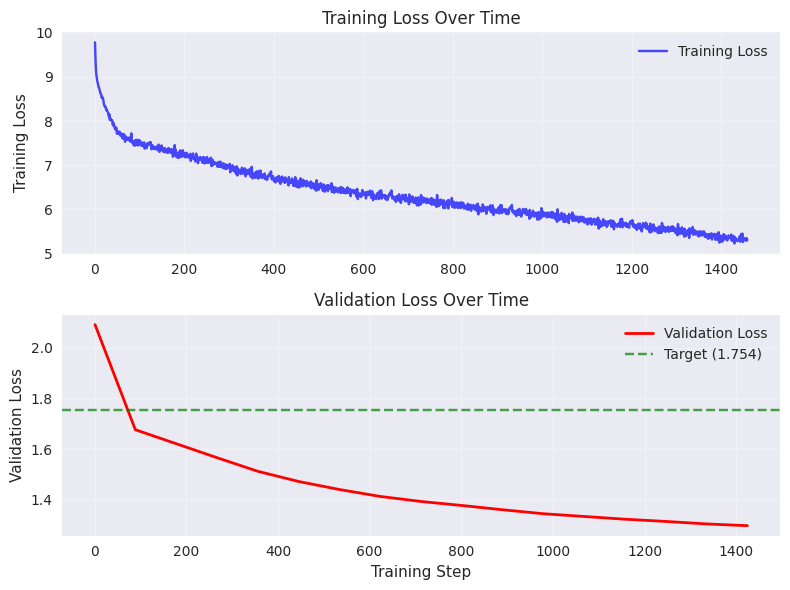

In [3]:
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Training and Validation Loss Over Time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Training loss
ax1.plot(train_df['step'], train_df['loss'], 'b-', alpha=0.7, label='Training Loss')
ax1.set_ylabel('Training Loss')
ax1.set_title('Training Loss Over Time')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Validation loss
ax2.plot(val_df['step'], val_df['loss'], 'r-', linewidth=2, label='Validation Loss')
ax2.axhline(y=1.754, color='g', linestyle='--', alpha=0.7, label='Target (1.754)')
ax2.set_xlabel('Training Step')
ax2.set_ylabel('Validation Loss')
ax2.set_title('Validation Loss Over Time')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

#### **Training and Validation Loss by Epoch**

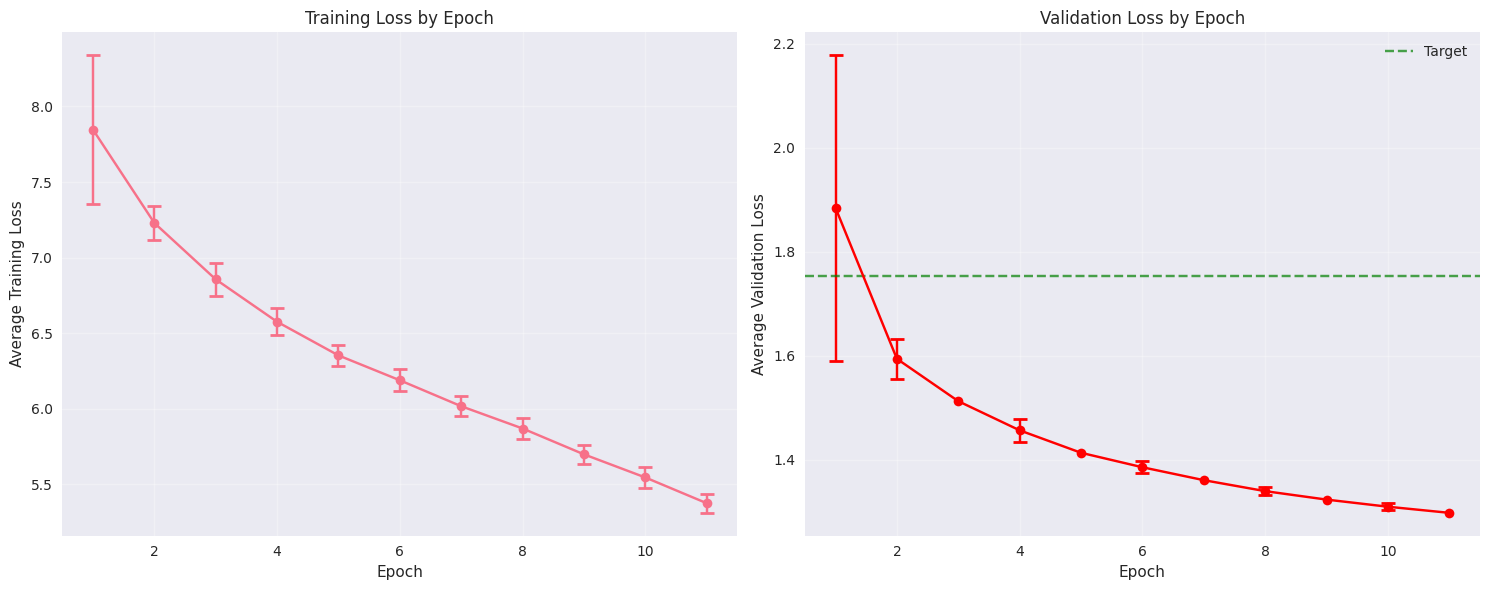

In [4]:
# Loss by Epoch
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Training loss by epoch
train_by_epoch = train_df.groupby('epoch')['loss'].agg(['mean', 'std']).reset_index()
ax1.errorbar(train_by_epoch['epoch'], train_by_epoch['mean'],
            yerr=train_by_epoch['std'], fmt='o-', capsize=5, capthick=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Training Loss')
ax1.set_title('Training Loss by Epoch')
ax1.grid(True, alpha=0.3)

# Validation loss by epoch
val_by_epoch = val_df.groupby('epoch')['loss'].agg(['mean', 'std']).reset_index()
ax2.errorbar(val_by_epoch['epoch'], val_by_epoch['mean'],
            yerr=val_by_epoch['std'], fmt='o-', capsize=5, capthick=2, color='red')
ax2.axhline(y=1.754, color='g', linestyle='--', alpha=0.7, label='Target')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Average Validation Loss')
ax2.set_title('Validation Loss by Epoch')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

#### **Training vs Validation Loss Comparision**

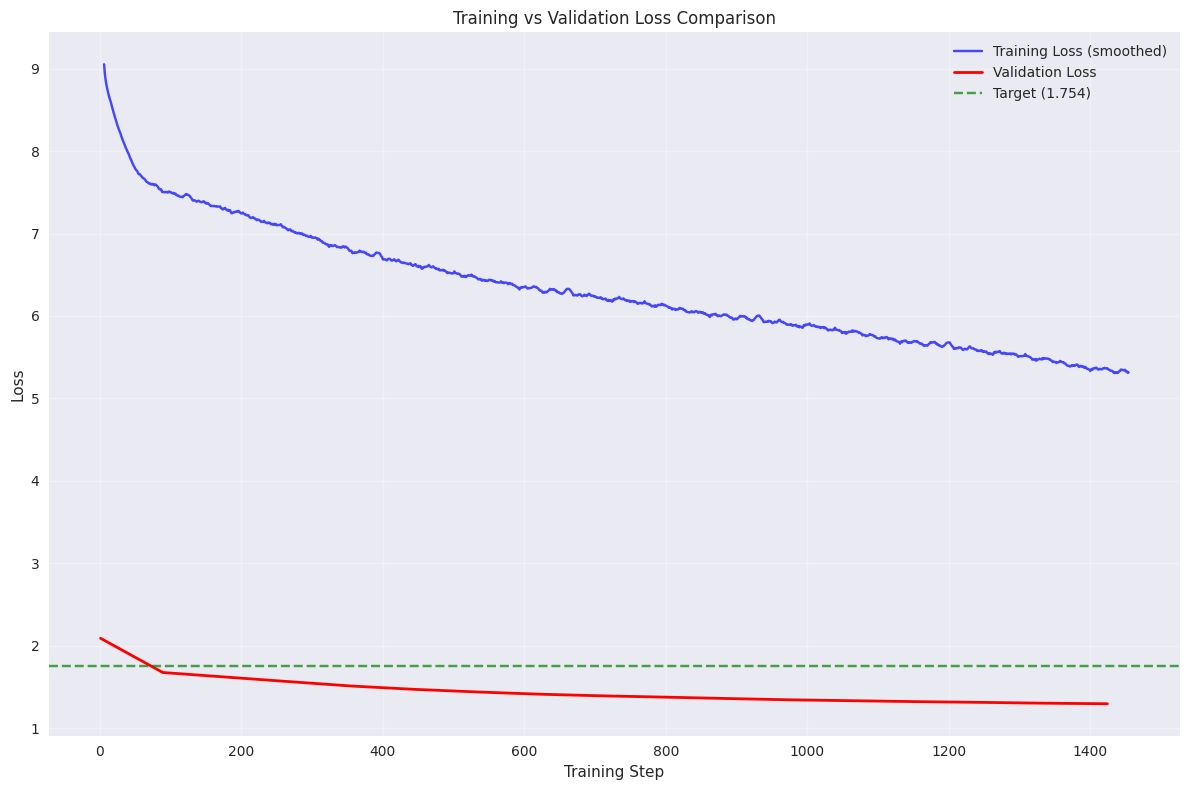

In [5]:
# Training vs Validation Loss Comparison
plt.figure(figsize=(12, 8))

# Smooth the training loss for better visualization
train_smooth = train_df['loss'].rolling(window=10, center=True).mean()

plt.plot(train_df['step'], train_smooth, 'b-', alpha=0.7, label='Training Loss (smoothed)')
plt.plot(val_df['step'], val_df['loss'], 'r-', linewidth=2, label='Validation Loss')
plt.axhline(y=1.754, color='g', linestyle='--', alpha=0.7, label='Target (1.754)')

plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### **Loss Distribution Analysis**

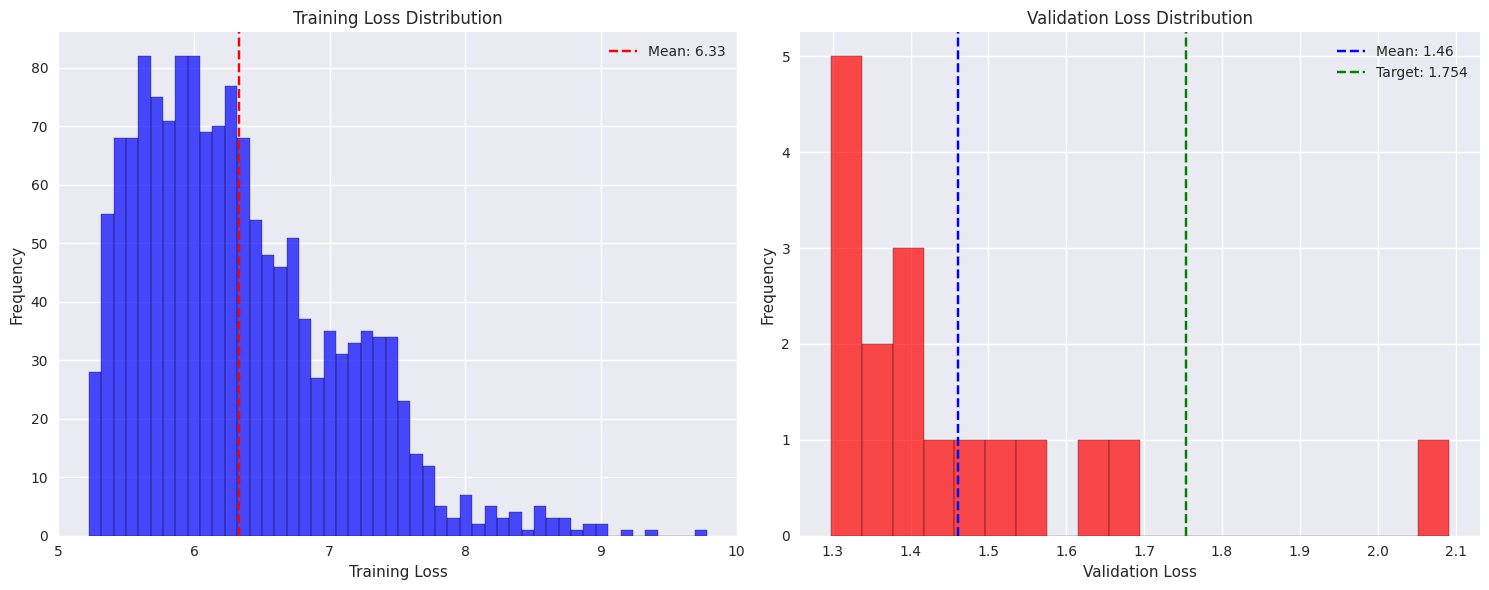

In [6]:
# Loss Distribution Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Training loss distribution
ax1.hist(train_df['loss'], bins=50, alpha=0.7, color='blue', edgecolor='black')
ax1.axvline(train_df['loss'].mean(), color='red', linestyle='--', label=f'Mean: {train_df["loss"].mean():.2f}')
ax1.set_xlabel('Training Loss')
ax1.set_ylabel('Frequency')
ax1.set_title('Training Loss Distribution')
ax1.legend()

# Validation loss distribution
ax2.hist(val_df['loss'], bins=20, alpha=0.7, color='red', edgecolor='black')
ax2.axvline(val_df['loss'].mean(), color='blue', linestyle='--', label=f'Mean: {val_df["loss"].mean():.2f}')
ax2.axvline(1.754, color='green', linestyle='--', label='Target: 1.754')
ax2.set_xlabel('Validation Loss')
ax2.set_ylabel('Frequency')
ax2.set_title('Validation Loss Distribution')
ax2.legend()

plt.tight_layout()
plt.show()

#### **Training Progress Analysis**

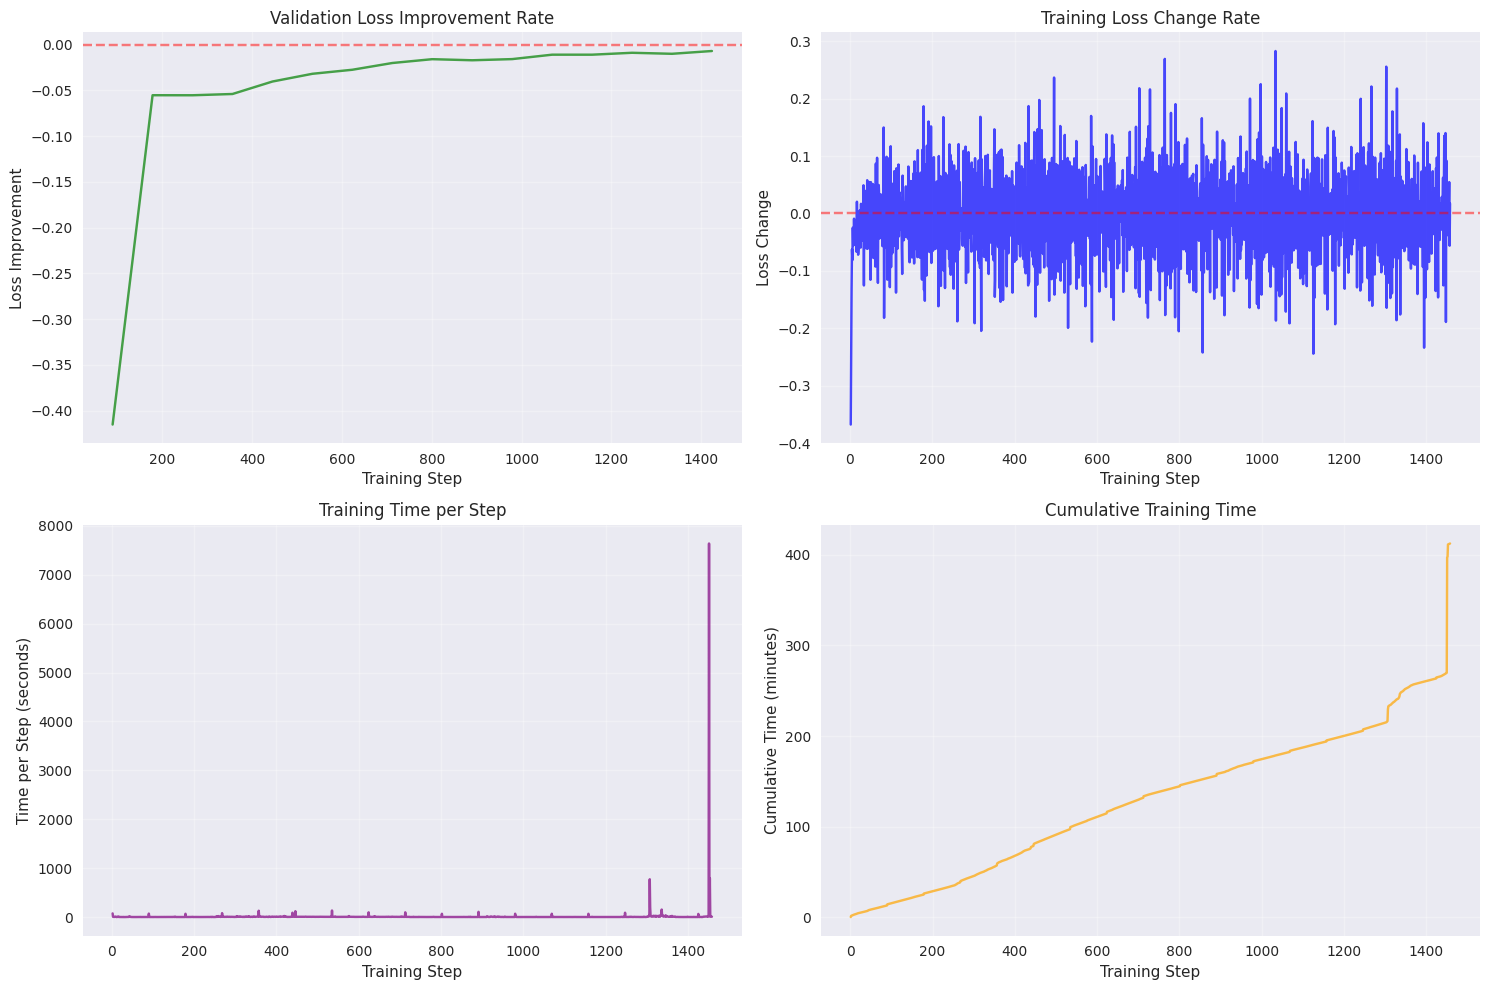

In [7]:
# Training Progress Analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Loss improvement rate
val_loss_diff = val_df['loss'].diff()
ax1.plot(val_df['step'][1:], val_loss_diff[1:], 'g-', alpha=0.7)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax1.set_xlabel('Training Step')
ax1.set_ylabel('Loss Improvement')
ax1.set_title('Validation Loss Improvement Rate')
ax1.grid(True, alpha=0.3)

# Training speed (loss per step)
train_loss_diff = train_df['loss'].diff()
ax2.plot(train_df['step'][1:], train_loss_diff[1:], 'b-', alpha=0.7)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Training Step')
ax2.set_ylabel('Loss Change')
ax2.set_title('Training Loss Change Rate')
ax2.grid(True, alpha=0.3)

# Time per step
time_per_step = train_df['elapsed_time'].diff()
ax3.plot(train_df['step'][1:], time_per_step[1:], 'purple', alpha=0.7)
ax3.set_xlabel('Training Step')
ax3.set_ylabel('Time per Step (seconds)')
ax3.set_title('Training Time per Step')
ax3.grid(True, alpha=0.3)

# Cumulative training time
ax4.plot(train_df['step'], train_df['elapsed_time'] / 60, 'orange', alpha=0.7)
ax4.set_xlabel('Training Step')
ax4.set_ylabel('Cumulative Time (minutes)')
ax4.set_title('Cumulative Training Time')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### **Learning Rate Visualization**

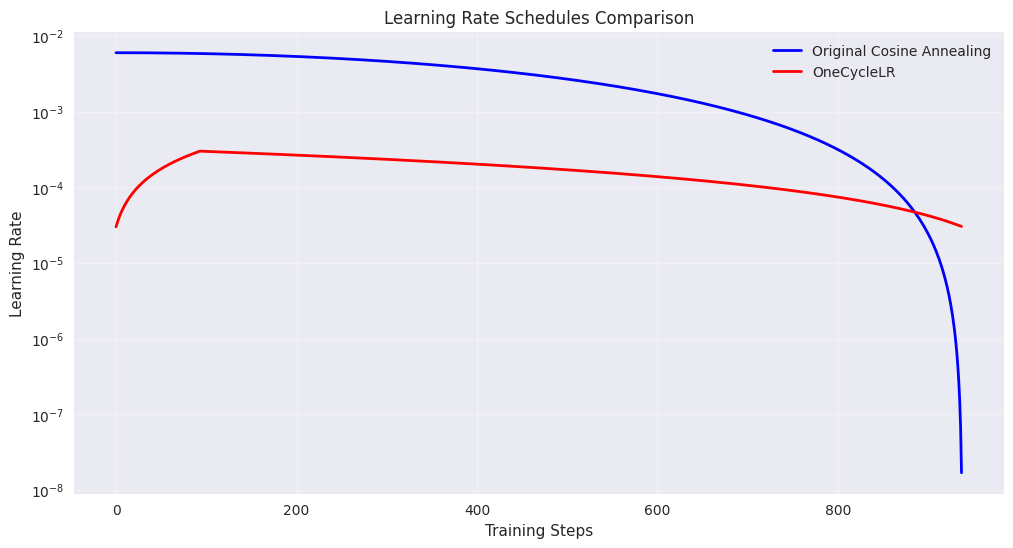

In [8]:
# Parameters
max_steps = 938
steps = np.arange(max_steps)

# Original Cosine Annealing
lr_original = 6e-3 * (1 + np.cos(np.pi * steps / max_steps)) / 2

# Your OneCycleLR
warmup_steps = max_steps // 10
max_lr = 3e-4
initial_lr = max_lr / 10

lr_onecycle = np.zeros(max_steps)
for i in range(max_steps):
    if i < warmup_steps:
        # Warmup phase
        lr_onecycle[i] = initial_lr + (max_lr - initial_lr) * i / warmup_steps
    else:
        # Annealing phase
        progress = (i - warmup_steps) / (max_steps - warmup_steps)
        lr_onecycle[i] = max_lr - (max_lr - initial_lr) * progress

plt.figure(figsize=(12, 6))
plt.plot(steps, lr_original, 'b-',
         label='Original Cosine Annealing', linewidth=2)
plt.plot(steps, lr_onecycle, 'r-', label='OneCycleLR', linewidth=2)
plt.xlabel('Training Steps')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedules Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

##**Log Comparison**

In [9]:
def parse_all_logs(log_directory):
    """Parse all log files and extract comparative data."""
    log_files = glob.glob(f"{log_directory}/*.log")
    all_runs = {}

    for log_file in log_files:
        run_name = Path(log_file).stem
        training_steps = []
        validation_steps = []
        hyperparams = {}
        dataset_info = {}
        model_info = {}

        with open(log_file, 'r') as f:
            for line in f:
                try:
                    data = json.loads(line.strip())
                    event = data.get('event', '')

                    if event == 'hyperparameters_configured':
                        hyperparams = {k: v for k, v in data.items() if k not in [
                            'event', 'timestamp']}

                    elif event == 'dataset_info':
                        dataset_info = {k: v for k, v in data.items() if k not in [
                            'event', 'timestamp']}

                    elif event == 'model_info':
                        model_info = {k: v for k, v in data.items() if k not in [
                            'event', 'timestamp']}

                    elif event == 'training_step':
                        training_steps.append({
                            'step': data.get('step', 0),
                            'loss': data.get('loss', 0),
                            'elapsed_time': data.get('elapsed_time', 0),
                        })

                    elif event == 'validation_step':
                        validation_steps.append({
                            'step': data.get('step', 0),
                            'loss': data.get('loss', 0),
                            'elapsed_time': data.get('elapsed_time', 0),
                        })

                except json.JSONDecodeError:
                    continue

        all_runs[run_name] = {
            'training': pd.DataFrame(training_steps),
            'validation': pd.DataFrame(validation_steps),
            'hyperparams': hyperparams,
            'dataset_info': dataset_info,
            'model_info': model_info
        }

    return all_runs


# Parse all logs
all_runs = parse_all_logs("../mainrun/logs/")


In [10]:
def analyze_convergence(all_runs):
    """Analyze how quickly each run converges."""
    convergence_metrics = {}

    for run_name, run_data in all_runs.items():
        val_df = run_data['validation']
        if not val_df.empty:
            # Find step where validation loss first drops below target
            target_loss = 1.754
            below_target = val_df[val_df['loss'] < target_loss]

            convergence_metrics[run_name] = {
                'steps_to_target': below_target['step'].min() if not below_target.empty else None,
                'final_val_loss': val_df['loss'].iloc[-1],
                'min_val_loss': val_df['loss'].min(),
                'total_steps': val_df['step'].max()
            }

    return pd.DataFrame(convergence_metrics).T


analyze_convergence(all_runs)

,steps_to_target,final_val_loss,min_val_loss,total_steps
mainrun_2025-08-07T12-55-22,89.0,1.290686,1.290686,1883.0
mainrun_2025-08-03T17-33-10,179.0,1.400935,1.400935,3766.0
mainrun_2025-08-04T20-53-00,178.0,1.324919,1.324919,1883.0
mainrun_2025-08-04T08-06-37,89.0,1.314220,1.314220,1780.0
mainrun_2025-08-07T05-46-25,89.0,1.295656,1.295656,1883.0
mainrun_2025-08-09T15-54-26,89.0,1.297543,1.297543,1424.0
baseline,748.0,1.753259,1.753259,938.0
mainrun_2025-08-06T19-06-06,89.0,1.283065,1.283065,1883.0
mainrun_2025-08-03T19-55-26,178.0,1.330705,1.330705,1883.0
mainrun_2025-08-08T06-01-07,89.0,1.326217,1.325987,1883.0


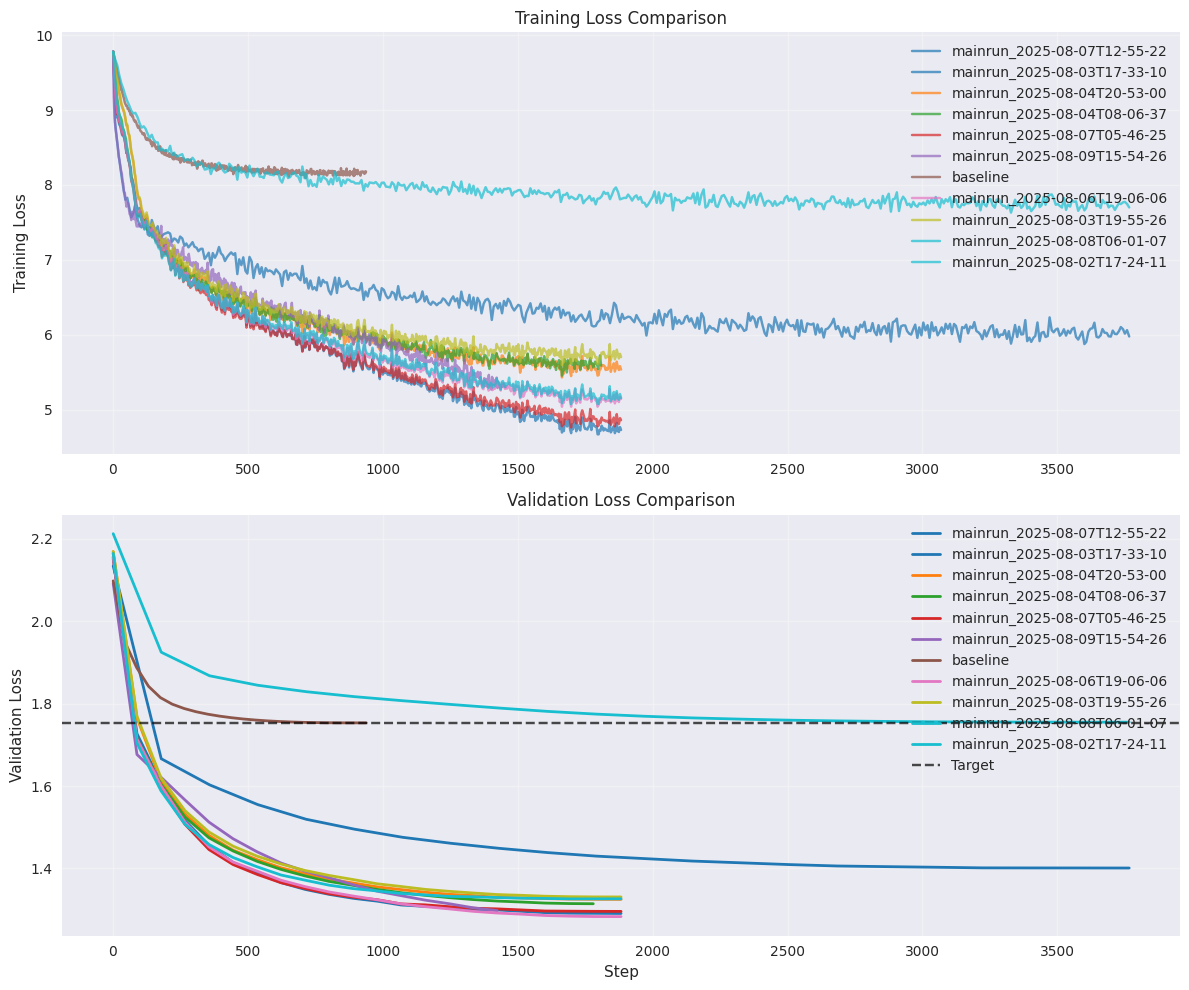

In [11]:
#  Learning Curve Comparison
def plot_learning_curves(all_runs):
    """Plot all learning curves together."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    colors = plt.cm.tab10(np.linspace(0, 1, len(all_runs)))

    for i, (run_name, run_data) in enumerate(all_runs.items()):
        train_df = run_data['training']
        val_df = run_data['validation']

        if not train_df.empty:
            # Sample training data for cleaner plots
            sample_idx = np.linspace(
                0, len(train_df)-1, min(500, len(train_df)), dtype=int)
            ax1.plot(train_df.iloc[sample_idx]['step'],
                     train_df.iloc[sample_idx]['loss'],
                     color=colors[i], alpha=0.7, label=run_name)

        if not val_df.empty:
            ax2.plot(val_df['step'], val_df['loss'],
                     color=colors[i], linewidth=2, label=run_name)

    ax1.set_ylabel('Training Loss')
    ax1.set_title('Training Loss Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.axhline(y=1.754, color='black', linestyle='--',
                alpha=0.7, label='Target')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Validation Loss')
    ax2.set_title('Validation Loss Comparison')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_learning_curves(all_runs)

In [12]:
# Loss Stability Analysis
def analyze_loss_stability(all_runs):
    """Analyze loss stability in final phases."""
    stability_metrics = {}

    for run_name, run_data in all_runs.items():
        val_df = run_data['validation']
        if len(val_df) > 10:
            # Look at last 20% of validation steps
            final_portion = val_df.tail(max(1, len(val_df) // 5))

            stability_metrics[run_name] = {
                'final_loss_std': final_portion['loss'].std(),
                'final_loss_mean': final_portion['loss'].mean(),
                'loss_trend': np.polyfit(range(len(final_portion)),
                                         final_portion['loss'], 1)[0]
            }

    return pd.DataFrame(stability_metrics).T


analyze_loss_stability(all_runs)

,final_loss_std,final_loss_mean,loss_trend
mainrun_2025-08-07T12-55-22,0.000304,1.290929,-0.000223
mainrun_2025-08-03T17-33-10,0.000108,1.401024,-0.000079
mainrun_2025-08-04T20-53-00,0.000306,1.325109,-0.000204
mainrun_2025-08-04T08-06-37,0.001886,1.315785,-0.001379
mainrun_2025-08-07T05-46-25,0.000245,1.295818,-0.000168
mainrun_2025-08-09T15-54-26,0.008398,1.305387,-0.008352
baseline,0.000051,1.753291,-0.000034
mainrun_2025-08-06T19-06-06,0.000517,1.283362,-0.000332
mainrun_2025-08-03T19-55-26,0.000301,1.330892,-0.000201
mainrun_2025-08-08T06-01-07,0.000123,1.326111,0.000088
